# Outline : Image denoising
Before diving into the code, lets recap what image denoise is.

Mathematically, a noisy image $y$ can be thought as being a sum between the latent image $x$ and some noise $n$ (N.B this is an approximation )  :
\begin{equation}
y = x + n 
\end{equation}

Ideally, we would want a network that learns how to extract the latent image, and one common formulation for the loss function in this setting is the MSE :
\begin{equation}
L = || y - x ||^2
\end{equation}
with $y$ being the input of the net ( the noisy image ) and $x$ being the ground truth ( the latent image). 

However, this specific formulation has a major issue, mainly related to the fact that learning such a task can lead to unstable training and vanishing gradient problems.

### A smart approach : Learning the residual

In order to solve the problems that a deep CNN inherently encounters when trying to solve the task described above, a residual approach has been found to lead better training and results. The idea is quite simple: instead of trying to making the net output directly the latent image ( a complex problem in general ) the network tries to learn the residual image i.e the difference between the noisy image and the latent image : 
\begin{equation}
R(y,w) = y - x 
\end{equation}
the image is then reconstructed from this residual representation.
Ideally, we would want the network to perfectly learn the noise in the image ( $R(y,w) \approx n$ ). It is immediate to derive a loss function from the above expression, since we would want the residual learned to be as close as $y-x$. Bringing each term on the left hand side, we can derive the loss function as a usual MSE:

\begin{equation}
L(y,w) = \frac{1}{2N}\sum_i^N  || R(y_i,w) - (y_i - x_i) ||^2
\end{equation}
with $w$ being the parameters of the network and $N$ being the samples in out training set.


# A CNN model for denoising

The architecture of the network is the same as the one described in https://arxiv.org/pdf/1608.03981.pdf

Refer to the paper to see the implementation details

In [1]:
import torch
import torch.nn as nn
from torch.nn import MSELoss
import torch.nn.functional as F

class DcNN(nn.Module):

    def __init__(self, n_channels : int, filter_size : int, kernel_size : int,  depth : int) -> None:
        super().__init__()

        """
        A quick recap on the parameters used by pytorch. 

        in_channels : the number of channels in the tensor.
    
        out_channels : this is the filter size of the convolution.

        kernel_size : this matches with the definition of the kernel

        Example :   input.shape =  (1, 3 , 256, 256)

                    conv2d = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3)

        pls note here that different kernel sizes affects the output shape. having it as 3 does not affect it when padding = 1

                    output = conv2d(input)

                    output.shape   ->   (1, 64, 256, 256)

        In summary, if one leaves the kernel to 3, with padding = 1 for each layer and no stride , the onnly value changing is the channel value.
        This means that first layer in this implementation is taking as input the number of channels, and spitting out a tensor with same shape 
        but with a number of channels equal to the filter size. The midlle layers are not altering the shape, and finally the final conv layer
        is returning the initial input shape
                
        """
        self.lossFunction = MSELoss(reduction="mean")

        self.firstConv = nn.Sequential(
                         nn.Conv2d(in_channels = n_channels, out_channels = filter_size, kernel_size = kernel_size, padding = 1),
                         nn.ReLU()
        )

     

        middleLayer = nn.Sequential(
                nn.Conv2d(in_channels = filter_size, out_channels = filter_size, kernel_size = kernel_size, padding = 1),
                nn.BatchNorm2d(64),
                nn.ReLU()
        )

        self.middleLayers = nn.Sequential(* [ middleLayer for _ in range(depth - 2) ])

        self.finalConv = nn.Conv2d(in_channels = filter_size, out_channels = n_channels, kernel_size = kernel_size, padding = 1)
        
    def forward(self, x):

        x = self.firstConv(x)
        x = self.middleLayers(x)
        out = self.finalConv(x)
        return out
    
    def loss(self, noisy_images : torch.Tensor, clean_images : torch.Tensor ) -> torch.float:
        """
                shape sizes : (batch_size, n_channels, width, height)
        
        """
        # loss = (R - ( y - x ) )^2      
        # R : residual       

        approximated_residual = self.forward(noisy_images)  #left term

        real_residual = noisy_images - clean_images #right term

        return self.lossFunction(approximated_residual, real_residual) 


In [13]:
# some hyper parameters

BATCH_SIZE = 64
PATCH_DIMENSION = 50
EPOCHS = 10

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"available device is {DEVICE}")
# initializing the model
model = DcNN(n_channels=3, filter_size=64, kernel_size=3, depth=20).to(DEVICE)
dummyRealImage = torch.rand((1, 3, 128, 128)).to(DEVICE)
dummyInput = torch.rand((1, 3, 128, 128)).to(DEVICE)
out = model(dummyInput)
dummyLoss = model.loss(dummyInput, dummyRealImage )
# print(f"The shape of the output is the same as the input! : input shape {dummyInput.shape}, output shape {out.shape}  ")
# print(f"The loss function works and the its value is {dummyLoss}")


available device is cuda



# Creating the training set : Gaussian noise
Staryting from a dataset of images, noisy images are simply obtained by adding gaussian noise with ranging std and mean to the clean image. Refer to the implementation in the dataset.py file.

The images are coming from the CBSD68 dataset. Downloaaded from https://github.com/clausmichele/CBSD68-dataset/tree/master


In [14]:
from dataset import NoisyDataset
from torch.utils.data import DataLoader
from torch.optim import Adam

dataset = NoisyDataset(dirPath="./dataset/original", stdRange=(0,55), batchSize=BATCH_SIZE, patchDimension=PATCH_DIMENSION)
dataloader = DataLoader(dataset=dataset, batch_size=None, shuffle=True, num_workers=4)
optimizer = Adam(model.parameters(), lr=0.001)



## Setting up the training loop

We follow the same training procedure followed by the paper


In [15]:
print(f"Training started ...  ")
for epoch in range(EPOCHS):

    model.train()
    totalLoss = 0 
    for input, groundT in dataloader:

        optimizer.zero_grad()  
        computedLoss = model.loss(noisy_images=input.to(DEVICE), clean_images=groundT.to(DEVICE))
        computedLoss.backward()
        optimizer.step()

        totalLoss += computedLoss.item()
        


    print(f"Model trained for {epoch} epoch, total loss is {totalLoss}")
    
torch.save(model.state_dict(), "paramter.pth")


Model trained for 0 epoch, total loss is 27.25514003011631
Model trained for 1 epoch, total loss is 14.42519600315427
Model trained for 2 epoch, total loss is 8.222462851677847
Model trained for 3 epoch, total loss is 5.339094784889312
Model trained for 4 epoch, total loss is 4.876633355852391


KeyboardInterrupt: 

torch.Size([3, 481, 321])


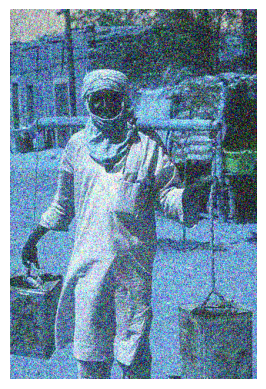

In [43]:
import utils
imageNumber = 12
sampleImage = dataset.noisyImages[imageNumber]
print(sampleImage.shape)
utils.plot_image(sampleImage)

In [44]:
inputUnsqueezed = torch.unsqueeze(sampleImage.to(DEVICE), dim=0)

residual = model(inputUnsqueezed)

residual = torch.squeeze(residual, dim=0).to("cpu")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


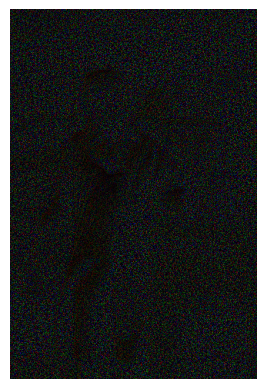

In [45]:
utils.plot_image(residual.to("cpu"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


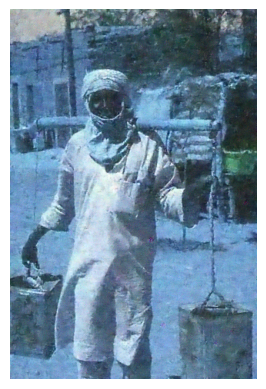

In [46]:
utils.plot_image(sampleImage - residual)

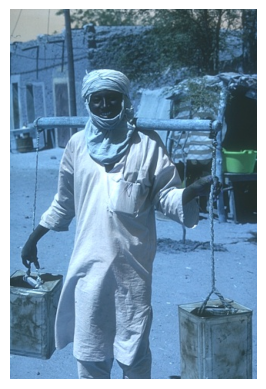

In [47]:
utils.plot_image(dataset.cleanImages[imageNumber])